In [1]:
# make sure venv is activated `source ./venv/bin/activate`
# !pip list
# !pip install -r requirements.txt

# TODO
# - implement VAE for protein sequences
# - multi-branch model for interaction prediction & how to set up loss?!
# - take a look at making the model more sound
# - Something to get molecular graphs of proteins? (https://graphein.ai/index.html)

In [2]:
import torch; print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.5.1+cu124
cuda


# Import DAVIS dataset

In [3]:
from tdc.multi_pred import DTI

data = DTI(name = 'DAVIS')
split = data.get_split()

Found local copy...
Loading...
Done!


In [4]:
print(split.keys())

print("Number of samples: ", len(split['train']) + len(split['valid']) + len(split['test']))
print("Train 7 / valid 1 / test sizes 2 :", len(split['train']), len(split['valid']), len(split['test']))
print("Range of drug-target interaction values: ", split['train']['Y'].min(), split['train']['Y'].max())

split['train'].head()

dict_keys(['train', 'valid', 'test'])
Number of samples:  25772
Train 7 / valid 1 / test sizes 2 : 18041 2577 5154
Range of drug-target interaction values:  0.016 10000.0


,Drug_ID,Drug,Target_ID,Target,Y
0,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,43.0
1,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL1p,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,10000.0
2,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL2,MVLGTVLLPPNSYGRDQDTSLCCLCTEASESALPDLTDHFASCVED...,10000.0
3,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR1,MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...,10000.0
4,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR2A,MGAAAKLAFAVFLISCSSGAILGRSETQECLFFNANWEKDRTNQTG...,10000.0


In [5]:
print(len(split['train']['Target'].unique()))

379


In [6]:
molecules = split['train']['Drug'].unique()
print(len(molecules))
molecules

68


array(['Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12',
       'CC(C)(C)c1cc(NC(=O)Nc2ccc(-c3cn4c(n3)sc3cc(OCCN5CCOCC5)ccc34)cc2)no1',
       'CCN1CCN(Cc2ccc(NC(=O)Nc3ccc(Oc4cc(NC)ncn4)cc3)cc2C(F)(F)F)CC1',
       'O=C(NC1CCNCC1)c1[nH]ncc1NC(=O)c1c(Cl)cccc1Cl',
       'CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC1CCOC1',
       'CN1CCC(c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc23)C(O)C1',
       'CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)n[nH]c2c1',
       'CCC1C(=O)N(C)c2cnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3OC)nc2N1C1CCCC1',
       'Cc1ccc2nc(NCCN)c3ncc(C)n3c2c1.Cl',
       'CCN(CCO)CCCOc1ccc2c(Nc3cc(CC(=O)Nc4cccc(F)c4)[nH]n3)ncnc2c1',
       'COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc23)c(Cl)cc1Cl',
       'Cc1cc2c(F)c(Oc3ncnn4cc(OCC(C)O)c(C)c34)ccc2[nH]1',
       'Cn1c(Nc2ccc(C(F)(F)F)cc2)nc2cc(Oc3ccnc(-c4ncc(C(F)(F)F)[nH]4)c3)ccc21',
       'O=C(NOCC1CC1)c1ccc(F)c(F)c1Nc1ccc(I)cc1Cl',
       'C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN1CCOCC1',
       'COc1cc2c(Oc3ccc4[nH]c(C)cc4c3F)ncnc

# Create molecular graph for molecule

In [7]:
subgraph_size = 50
print(subgraph_size*subgraph_size)
print(subgraph_size*subgraph_size - subgraph_size)
2 * subgraph_size * (subgraph_size - 1) // 4

2500
2450


1225

In [8]:
subgraphs=[6, 12, 25, 50]
n_nodes = 50

subgraphs.append(n_nodes) if subgraphs[-1] != n_nodes else None

subgraphs

[6, 12, 25, 50]

Number of batches:  5 	samples:  68
Max number of atoms (i.e. nodes):  46

Example molecule 2 :  CCN1CCN(Cc2ccc(NC(=O)Nc3ccc(Oc4cc(NC)ncn4)cc3)cc2C(F)(F)F)CC1
Number of atoms:  38
Number of bonds:  41


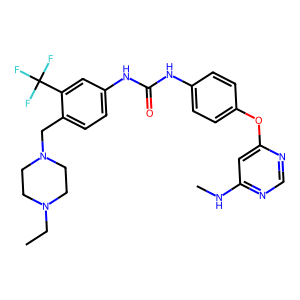

Converting SMILES to torch_geometric Data instance for:  CCN1CCN(Cc2ccc(NC(=O)Nc3ccc(Oc4cc(NC)ncn4)cc3)cc2C(F)(F)F)CC1
Number of nodes:  38
Node features:  torch.Size([38, 9]) 
- example: tensor([6, 0, 4, 5, 3, 0, 4, 0, 0]) 
- out of classes:  [119, 9, 11, 12, 9, 5, 8, 2, 2]

Number of edges:  82
Edges have to be represented undirected as a COO tensor
Edge features:  torch.Size([82, 3]) 
- example: tensor([1, 0, 0]) 
- out of classes:  [22, 6, 2]


Data(x=[38, 9], edge_index=[2, 82], edge_attr=[82, 3], smiles='CCN1CCN(Cc2ccc(NC(=O)Nc3ccc(Oc4cc(NC)ncn4)cc3)cc2C(F)(F)F)CC1')

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw
from torch_geometric.data import DataLoader
from encoding.DataEncoders import smiles2pydata

BATCHE_SIZE = 16

molecules_loader = DataLoader(
    [smiles2pydata(m, with_hydrogen=False) for m in molecules], 
    batch_size=BATCHE_SIZE, 
    shuffle=True)

example_index = 2
print("Number of batches: ", len(molecules_loader), "\tsamples: ", len(molecules_loader.dataset))
print("Max number of atoms (i.e. nodes): ", max([data.num_nodes for data in molecules_loader.dataset]))
print("\nExample molecule", example_index, ': ', molecules[example_index])
example_drug = smiles2pydata(molecules[example_index], with_hydrogen=False, give_description=True)
for batch in molecules_loader:
    example_drug_batch = batch
    break

num_node_features = example_drug.x.shape[1]
num_edge_features = example_drug.edge_attr.shape[1]
example_drug

In [10]:
# node features map: [119, 9, 11, 12, 9, 5, 8, 2, 2]
example_drug_batch

DataBatch(x=[499, 9], edge_index=[2, 1098], edge_attr=[1098, 3], smiles=[16], batch=[499], ptr=[17])

In [17]:
from models.MolecularGraphVAE import MolGraphVAEncoder

encoder_model = MolGraphVAEncoder()
mean, logvar, adj_matrices = encoder_model(example_drug, debug=True)
print("\nMu and logstd: ", mean.shape, logvar.shape)
print("\nAdjacency matrices: ", [a.shape for a in adj_matrices])

Data:  torch.Size([38, 64]) torch.Size([2, 82]) torch.Size([82, 16])
Embeddings:  torch.Size([38, 64]) torch.Size([82, 16])
Output:  torch.Size([1, 128])
First convolution:  torch.Size([38, 1024]) torch.Size([2, 82]) torch.Size([82, 16])
Second convolution:  torch.Size([38, 128]) torch.Size([2, 82]) torch.Size([82, 16])

Convolution:  torch.Size([38, 128]) torch.Size([2, 82]) torch.Size([82, 16])
Pooling:  torch.Size([25, 128]) torch.Size([2, 38]) torch.Size([38, 16])
Adjacency:  torch.Size([1, 25, 25])

Convolution:  torch.Size([25, 128]) torch.Size([2, 38]) torch.Size([38, 16])
Pooling:  torch.Size([12, 128]) torch.Size([2, 10]) torch.Size([10, 16])
Adjacency:  torch.Size([1, 12, 12])

Convolution:  torch.Size([12, 128]) torch.Size([2, 10]) torch.Size([10, 16])
Pooling:  torch.Size([6, 128]) torch.Size([2, 2]) torch.Size([2, 16])
Adjacency:  torch.Size([1, 6, 6])

Mu and logstd:  torch.Size([1, 64]) torch.Size([1, 64])

Adjacency matrices:  [torch.Size([1, 25, 25]), torch.Size([1, 12

In [18]:
mean, logvar, adj_matrices = encoder_model(example_drug_batch, debug=True)
print("\nMu and logstd: ", mean.shape, logvar.shape)
print("Adjacency matrices: ", [a.shape for a in adj_matrices])
len(example_drug_batch)

Data:  torch.Size([499, 64]) torch.Size([2, 1098]) torch.Size([1098, 16])
Embeddings:  torch.Size([499, 64]) torch.Size([1098, 16])
Output:  torch.Size([16, 128])
First convolution:  torch.Size([499, 1024]) torch.Size([2, 1098]) torch.Size([1098, 16])
Second convolution:  torch.Size([499, 128]) torch.Size([2, 1098]) torch.Size([1098, 16])

Convolution:  torch.Size([499, 128]) torch.Size([2, 1098]) torch.Size([1098, 16])
Pooling:  torch.Size([398, 128]) torch.Size([2, 802]) torch.Size([802, 16])
Adjacency:  torch.Size([16, 25, 25])

Convolution:  torch.Size([398, 128]) torch.Size([2, 802]) torch.Size([802, 16])
Pooling:  torch.Size([192, 128]) torch.Size([2, 242]) torch.Size([242, 16])
Adjacency:  torch.Size([16, 12, 12])

Convolution:  torch.Size([192, 128]) torch.Size([2, 242]) torch.Size([242, 16])
Pooling:  torch.Size([96, 128]) torch.Size([2, 86]) torch.Size([86, 16])
Adjacency:  torch.Size([16, 6, 6])

Mu and logstd:  torch.Size([16, 64]) torch.Size([16, 64])
Adjacency matrices:  

16

---
---

In [19]:
sum(p.numel() for p in encoder_model.parameters() if p.requires_grad)

554406

In [19]:
from torch_geometric.utils import to_dense_adj
to_dense_adj(
    edge_index = example_drug.edge_index, 
    edge_attr = example_drug.edge_attr,
    max_num_nodes=50
).shape # also works in batches

torch.Size([1, 50, 50, 3])

In [45]:
# nn.Linear(hidden_dim, 2*n_nodes*(n_nodes-1)//2)
n_nodes = 20
print(n_nodes * n_nodes)
2 * n_nodes * (n_nodes - 1) // 2

400


380

In [25]:
list(map(len, [key for key in x_map.values()]))

[119, 9, 11, 12, 9, 5, 8, 2, 2]

In [22]:
from torch_geometric.utils.smiles import x_map, e_map

print(sum(list(map(len, [key for key in x_map.values()]))))
print(sum(list(map(len, [key for key in e_map.values()]))))

177
30


In [46]:
list(map(len, [key for key in e_map.values()]))

[22, 6, 2]

In [48]:
list(map(len, [key for key in x_map.values()]))[0]

119

In [51]:
len(x_map["atomic_num"])

119

In [58]:
fc_result = torch.rand(1, n_nodes * len(x_map["atomic_num"]))
print(fc_result.shape)

x = torch.reshape(fc_result, (fc_result.size(0), 50, -1))
print(x.shape)
print(x[0, 0, :5])

x = torch.nn.functional.softmax(x, dim=2)
print(x[0, 0, :5])
print(sum(x[0, 0, :]))

torch.Size([1, 5950])
torch.Size([1, 50, 119])
tensor([0.3259, 0.6289, 0.5341, 0.7637, 0.0391])
tensor([0.0069, 0.0093, 0.0084, 0.0106, 0.0051])
tensor(1.0000)


In [72]:
2 * (n_nodes * (n_nodes - 1) // 2) * len(e_map["bond_type"])

53900

In [65]:
(n_nodes * (n_nodes - 1) // 2) * len(e_map["bond_type"])

26950

In [69]:
(50 * 50 - 50) // 2 * len(e_map["bond_type"])

26950

In [79]:
fc_result = torch.rand(1, (2 * n_nodes * (n_nodes - 1) // 2) * len(e_map["bond_type"]))
print(fc_result.shape)

x = torch.reshape(fc_result, (fc_result.size(0), -1, 2, len(e_map["bond_type"])))
print(x.shape)

x = torch.nn.functional.gumbel_softmax(
    x, tau=1, hard=True)[:,:,0,:]
print(x.shape)

adj = torch.zeros(1, n_nodes, n_nodes, len(e_map["bond_type"]))
print(adj.shape)

idx = torch.triu_indices(n_nodes, n_nodes, offset=1)
print(idx.shape)

adj[0, idx[0], idx[1], :] = x
adj = adj + torch.transpose(adj, 1, 2)
print(adj.shape)

torch.Size([1, 53900])
torch.Size([1, 1225, 2, 22])
torch.Size([1, 1225, 22])
torch.Size([1, 50, 50, 22])
torch.Size([2, 1225])
torch.Size([1, 50, 50, 22])


In [64]:
n_nodes = 50
fc_result = torch.rand(1, 2 * n_nodes * (n_nodes - 1) // 2)
print(fc_result.shape)

x = torch.reshape(fc_result, (fc_result.size(0), -1, 2))
print(x.shape)

x = torch.nn.functional.gumbel_softmax(
            x, tau=1, hard=True)[:,:,0] # sample from categorical distribution
print(x.shape)

adj = torch.zeros(x.size(0), n_nodes, n_nodes) # empty adjacency matrix
print(adj.shape)

idx = torch.triu_indices(n_nodes, n_nodes, 1)
adj[:, idx[0], idx[1]] = x
adj = adj + torch.transpose(adj, 1, 2)

torch.Size([1, 2450])
torch.Size([1, 1225, 2])
torch.Size([1, 1225])
torch.Size([1, 50, 50])


---
---
---

In [218]:
import torch.optim as optim
from torch_geometric.utils import negative_sampling

def train(model, data_loader, epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for data in data_loader:
            optimizer.zero_grad()
            z = model.encode(data)
            loss = model.recon_loss(z, data.edge_index)
            loss = loss + (1 / data.num_nodes) * model.kl_loss()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(data_loader)}')

model = VGAE(VariationalGATEncoder(in_channels=example.x.shape[-1], hidden_channels=32, latent_dim=16))
# model = model.to(device)
train(model, train_loader)

Epoch 1, Loss: 2.624526047706604
Epoch 2, Loss: 1.4406317472457886
Epoch 3, Loss: 1.285384440422058
Epoch 4, Loss: 1.2970892906188964
Epoch 5, Loss: 1.2825347423553466
Epoch 6, Loss: 1.2505077600479126
Epoch 7, Loss: 1.2233814001083374
Epoch 8, Loss: 1.2196834325790404
Epoch 9, Loss: 1.2311196804046631
Epoch 10, Loss: 1.2034215688705445
Epoch 11, Loss: 1.2116324663162232
Epoch 12, Loss: 1.1705181121826171
Epoch 13, Loss: 1.1873178005218505
Epoch 14, Loss: 1.177670955657959
Epoch 15, Loss: 1.1681327819824219
Epoch 16, Loss: 1.1502191543579101
Epoch 17, Loss: 1.1602381229400636
Epoch 18, Loss: 1.1932204961776733
Epoch 19, Loss: 1.1582868337631225
Epoch 20, Loss: 1.1721254348754884
Epoch 21, Loss: 1.1418792724609375
Epoch 22, Loss: 1.1283941745758057
Epoch 23, Loss: 1.1330655097961426
Epoch 24, Loss: 1.1296535730361938
Epoch 25, Loss: 1.1393168210983275
Epoch 26, Loss: 1.1348979949951172
Epoch 27, Loss: 1.1351196765899658
Epoch 28, Loss: 1.1524305105209351
Epoch 29, Loss: 1.12045772075653

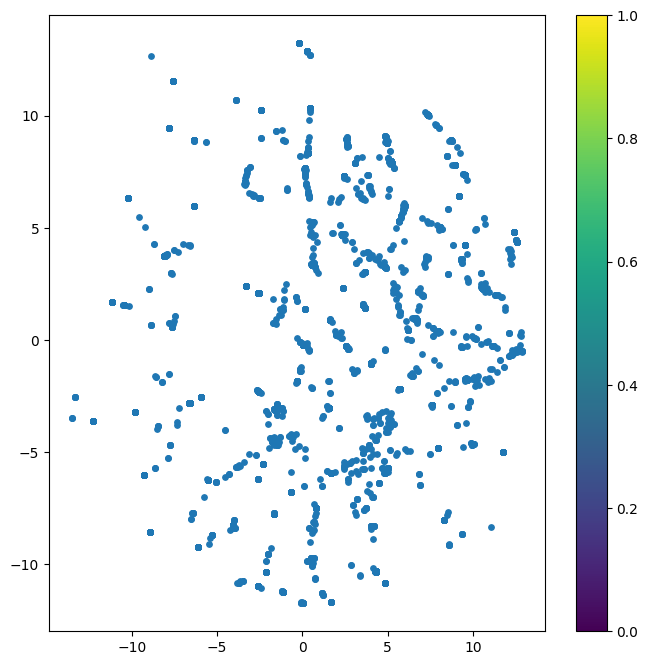

In [206]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'z' is your latent space encoding
def visualize_latent_space(embeddings, labels=None):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    z_2d = tsne.fit_transform(embeddings.cpu().detach().numpy())

    plt.figure(figsize=(8, 8))
    plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='viridis', s=15)
    plt.colorbar()
    plt.show()

# Sample latent space embeddings from your VGAE
model.eval()
with torch.no_grad():
    embeddings = []
    for data in train_loader:
        _, z = model(data)
        embeddings.append(z)
    embeddings = torch.cat(embeddings, dim=0)

# Visualize the latent space (assuming no specific labels for molecules)
visualize_latent_space(embeddings)

TaniMoto similarity, fingerprints om smiles strings te vergelijken en zo te zien of deze embedding-space iteressant is.

Presentatie in december!

In [165]:
def sample_latent_space(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)  # Standard normal distribution
    return mu + eps * std

mu, logvar = vgae_model.encoder(data.x, data.edge_index)
z_sampled = sample_latent_space(mu, logvar)
reconstructed_adj = vgae_model.decoder(z_sampled)
adj_pred = (reconstructed_adj > 0.5).float()  # Threshold to get binary adjacency matrix

torch.Size([253, 253])

---
---

In [204]:
drugs = split['train']['Drug'].unique()
print(drugs)

prots = split['train']['Target'].values[0:5]
print(prots)

ys = split['train']['Y'].values[0:5]
print(ys)

['Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12'
 'CC(C)(C)c1cc(NC(=O)Nc2ccc(-c3cn4c(n3)sc3cc(OCCN5CCOCC5)ccc34)cc2)no1'
 'CCN1CCN(Cc2ccc(NC(=O)Nc3ccc(Oc4cc(NC)ncn4)cc3)cc2C(F)(F)F)CC1'
 'O=C(NC1CCNCC1)c1[nH]ncc1NC(=O)c1c(Cl)cccc1Cl'
 'CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC1CCOC1'
 'CN1CCC(c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc23)C(O)C1'
 'CNC(=O)c1ccccc1Sc1ccc2c(C=Cc3ccccn3)n[nH]c2c1'
 'CCC1C(=O)N(C)c2cnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3OC)nc2N1C1CCCC1'
 'Cc1ccc2nc(NCCN)c3ncc(C)n3c2c1.Cl'
 'CCN(CCO)CCCOc1ccc2c(Nc3cc(CC(=O)Nc4cccc(F)c4)[nH]n3)ncnc2c1'
 'COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc23)c(Cl)cc1Cl'
 'Cc1cc2c(F)c(Oc3ncnn4cc(OCC(C)O)c(C)c34)ccc2[nH]1'
 'Cn1c(Nc2ccc(C(F)(F)F)cc2)nc2cc(Oc3ccnc(-c4ncc(C(F)(F)F)[nH]4)c3)ccc21'
 'O=C(NOCC1CC1)c1ccc(F)c(F)c1Nc1ccc(I)cc1Cl'
 'C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN1CCOCC1'
 'COc1cc2c(Oc3ccc4[nH]c(C)cc4c3F)ncnc2cc1OCCCN1CCCC1'
 'CC(Oc1cc(-c2cnn(C3CCNCC3)c2)cnc1N)c1c(Cl)ccc(F)c1Cl'
 'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)c

In [205]:
import numpy as np
from smiles_encoder import SmilesEncoder
import blosum as bl


SMILES_encoder = SmilesEncoder(list(split['train']['Drug'].unique()))


def encode_drugs(drugs, encoder = SMILES_encoder, padding = True, size = None):
    """
    Encodes a batch of drug sequences using the SMILES_encoder.

    Parameters
    ----------
    drug : list of str
        The list of drug sequences to encode.
    encoder : SmilesEncoder
        The SMILES_encoder to use. Default is SMILES_encoder.
    padding : bool
        Whether to pad the sequences with zeros if they are shorter than the specified size. Default is True.
    size : int or None
        The maximum length of the encoded sequences. If None, it will be set to the length of the longest sequence.

    Returns
    -------
    torch.Tensor
        A tensor of shape (instances, seq_len, features).
    """
    vocab_size = len(encoder.element_dict.keys())
    # Determine the maximum sequence length
    if size is None:
        size = max(len(seq) for seq in drugs)

    # Initialize a list to hold the encoded sequences
    encoded_sequences = []

    for drug in drugs:
        encoding = encoder.encode(drug)
        
        # If padding is enabled and the sequence is shorter than the specified size
        if padding:
            to_pad = size - len(encoding)
            padding_array = np.zeros((to_pad, vocab_size))
            encoding = np.vstack((encoding, padding_array))

        encoded_sequences.append(encoding)

    return torch.tensor(np.array(encoded_sequences))


print("Drugs:")
drugs_encoded = encode_drugs(drugs)
print(drugs_encoded.shape)  # Expected shape: (instances, seq_len, features)


def encode_prots(sequences, blosum=62, padding=True, size=None):
    """
    Encodes a batch of protein sequences using the BLOSUM matrix.

    Parameters
    ----------
    sequences : list of str
        The list of protein sequences to encode.
    blosum : int
        The BLOSUM matrix to use. Default is 62.
    padding : bool
        Whether to pad the sequences with zeros if they are shorter than the specified size. Default is True.
    size : int or None
        The maximum length of the encoded sequences. If None, it will be set to the length of the longest sequence.

    Returns
    -------
    torch.Tensor
        A tensor of shape (instances, seq_len, vocab_size).
    """
    # Load the BLOSUM matrix
    matrix = bl.BLOSUM(blosum)
    vocab_size = len(matrix)
    # Determine the maximum sequence length
    if size is None:
        size = max(len(seq) for seq in sequences)

    # Initialize a list to hold the encoded sequences
    encoded_sequences = []

    for sequence in sequences:
        # Initialize the encoding matrix for this sequence
        encoding = np.zeros((size, vocab_size))
        # Encode the sequence using the BLOSUM matrix
        for i, aa in enumerate(sequence):
            if i >= size:
                break  # Stop if the sequence exceeds the specified size
            vector = np.array([matrix[vocab_aa][aa] for vocab_aa in matrix.keys()])
            encoding[i, :] = np.tanh(vector)  # Apply tanh normalization

        # If padding is enabled and the sequence is shorter than the specified size
        if padding and len(sequence) < size:
            to_pad = size - len(sequence)
            encoding[len(sequence):, :] = np.zeros((to_pad, vocab_size))

        encoded_sequences.append(encoding)

    # Convert the list of encoded sequences to a tensor
    encoded_sequences = torch.tensor(np.array(encoded_sequences))
    
    return encoded_sequences


# Example usage for proteins
print("Proteins:")
# Assume `prots` is a list of protein sequences
prots_encoded = encode_prots(prots, size=split['train']['Target'].str.len().max())
print(prots_encoded.shape)  # Expected shape: (instances, seq_len, features)

Drugs:
torch.Size([68, 81, 57])
Proteins:
torch.Size([5, 2549, 25])


In [223]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim=64, kernel_size=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size, padding="same"),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(hidden_dim)
        )

    def forward(self, x):
        return self.net(x) + x

class Encoder(nn.Module):                               # input shape: [1, 81, 57]
    def __init__(self, bottleneck_size=8):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(3, 3)),        # Output: (8, 79, 55)
            ResidualBlock(8),
            nn.MaxPool2d(2),                            # Output: (8, 39, 27)
            ResidualBlock(8),
            nn.Conv2d(8, 16, kernel_size=(3, 3)),       # Output: (16, 37, 25)
            ResidualBlock(16),
            nn.MaxPool2d(2),                            # Output: (16, 18, 12)
            ResidualBlock(16),
            nn.Conv2d(16, 16, kernel_size=(3, 3)),      # Output: (16, 16, 10)
        )
        self.flatten = nn.Flatten()
        self.MLP = nn.Linear(16 * 16 * 10, bottleneck_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Adding channel dimension for CNN input
        return self.MLP(self.flatten(self.cnn(x)))

class Decoder(nn.Module):
    def __init__(self, bottleneck_size=8):
        super().__init__()
        self.unflatten = nn.Unflatten(1, (16, 16, 10))      # Adjusted to match the encoder output
        self.MLP = nn.Linear(bottleneck_size, 16 * 16 * 10) # Adjusted input size to match encoder output
        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=(3, 3)), # Output: (16, 18, 12)
            ResidualBlock(16),
            nn.Upsample(scale_factor=2),                    # Output: (16, 36, 25)
            ResidualBlock(16),
            nn.ConvTranspose2d(16, 8, kernel_size=(3, 3)),  # Output: (8, 38, 26)
            ResidualBlock(8),
            nn.Upsample(scale_factor=2),                    # Output: (8, 76, 52)
            ResidualBlock(8),
            nn.ConvTranspose2d(8, 1, kernel_size=(6, 6)),   # Output: (1, 81, 57)
        )

    def forward(self, x):
        x = self.unflatten(self.MLP(x))
        return self.cnn(x).squeeze(1)  # Remove the channel dimension

class VariationalAutoEncoder(nn.Module):
    def __init__(self, bottleneck_size=8):
        super().__init__()
        self.encoder = Encoder(bottleneck_size=bottleneck_size)
        self.linear_to_means = nn.Linear(bottleneck_size, bottleneck_size)
        self.linear_to_logvars = nn.Linear(bottleneck_size, bottleneck_size)
        self.decoder = Decoder(bottleneck_size=bottleneck_size)

    def encode(self, x):
        z = self.encoder(x)
        z_means = self.linear_to_means(z)
        z_logvars = self.linear_to_logvars(z)
        return z, z_means, z_logvars

    def decode(self, x):
        return self.decoder(x)

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        encoding, z_means, z_logvars = self.encode(x)
        z = self.reparameterization(z_means, z_logvars)
        x_reconstructed = self.decode(z)
        return x_reconstructed, z, z_means, z_logvars

In [224]:
model = VariationalAutoEncoder(bottleneck_size = 8)

x = torch.randn(16, 81, 57)
print("original shape of x:")
print(x.shape)

print("\nTesting encoder:")
encoding, z_means, z_logvars = model.encode(x)
print(encoding.shape, z_means.shape, z_logvars.shape)

print("\nTesting reparameterization:")
z = model.reparameterization(z_means, z_logvars)
print(z.shape)

print("\nTesting decoder:")
x_decoded = model.decode(z)
print(x_decoded.shape)

print("\nTesting whole model at once:")
x_reconstructed, z, z_means, z_logvars = model(x)
print(x_reconstructed.shape)

original shape of x:
torch.Size([16, 81, 57])

Testing encoder:
torch.Size([16, 8]) torch.Size([16, 8]) torch.Size([16, 8])

Testing reparameterization:
torch.Size([16, 8])

Testing decoder:
torch.Size([16, 81, 57])

Testing whole model at once:
torch.Size([16, 81, 57])


In [213]:
import torch.nn.functional as F

class VAELoss(nn.Module):
    def __init__(self, beta = 0.001):
        super().__init__()
        self.beta = beta

    def forward(self, x_reconstruct, means, logvars, x_true):
        # Reconstruction loss based on MSE over entire input & reconstructed output
        reconstruction_loss = F.mse_loss(x_reconstruct, x_true)
        # KL divergence loss to force distribution close Gaussian
        KL_div_loss = (-0.5 * torch.sum(1 + logvars - means**2 - logvars.exp())) / means.size(1)

        return reconstruction_loss + self.beta * KL_div_loss

In [215]:
N_EPOCHS = 20

# Initialize model
model = VariationalAutoEncoder(bottleneck_size = 8).to("cuda")

# Initialize custom loss function used to compute loss during training
loss_function = VAELoss(beta = 0.001)

# Initialize optimizer used to update model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(N_EPOCHS):
    model.train() # allow for parameters to be updated
    optimizer.zero_grad() # set gradients of model parameters to zero
    X = drugs_encoded.float()
    X = X.to("cuda")

    # TODO: use z's of different VAEs to compute interaction / modality losses
    x_reconstruct, z, z_means, z_logvars = model(X)
    loss = loss_function(x_reconstruct, z_means, z_logvars, X)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}: loss = {loss.item()}")

Epoch 0: loss = 8.807698249816895
Epoch 1: loss = 7.2431535720825195
Epoch 2: loss = 6.205906391143799
Epoch 3: loss = 5.426946640014648
Epoch 4: loss = 4.954860210418701
Epoch 5: loss = 4.441951274871826
Epoch 6: loss = 4.089791774749756
Epoch 7: loss = 3.847390651702881
Epoch 8: loss = 3.5727007389068604
Epoch 9: loss = 3.3548905849456787
Epoch 10: loss = 3.1461923122406006
Epoch 11: loss = 2.938033103942871
Epoch 12: loss = 2.7777082920074463
Epoch 13: loss = 2.5764713287353516
Epoch 14: loss = 2.505385160446167
Epoch 15: loss = 2.305211305618286
Epoch 16: loss = 2.2119007110595703
Epoch 17: loss = 2.124023914337158
Epoch 18: loss = 2.0225987434387207
Epoch 19: loss = 1.9356749057769775
